###Importing and splitting data into training and testing

In [0]:
from __future__ import print_function

import logging
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import pandas as pd

from time import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import homogeneity_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import preprocessing


In [0]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

2018-11-30 16:52:50,738 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012


Automatically created module for IPython interactive environment


2018-11-30 16:52:51,051 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2018-11-30 16:52:51,265 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2018-11-30 16:52:51,604 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` in

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


###Computing PCA

In [0]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 50

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_std = preprocessing.scale(X_train,with_mean=False, with_std=True, copy=True)
y_train_std = preprocessing.scale(y_train,with_mean=False, with_std=True, copy=True)

print("done in %0.3fs" % (time() - t0))

Extracting the top 50 eigenfaces from 966 faces
done in 0.243s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.042s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


###SVM classification model

####Change the parameter grid for ‘C’ to include the values (1, 10, 100, 1e3). Lower values of ‘C’ allows the classifier to handle more difficult datasets, as it can better tolerate misclassified points

cpu runtime: 115.009s
gpu runtime: 91.114 seconds
tpu runtime:116.308 seconds

In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
# best C was 1000 and remained the same after adding lower values
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.123s
Best estimator found by grid search:


####Plot the number of principal components on the x-axis, and the performance and the corresponding C values found by grid search on the Y-axis.

In [0]:
x = [50,150,190,300,1000]
y= [10,1,10,10,10]
z = [83,87,85,81,39]

fig,ax1 = plt.subplots()

ax1.set_xlabel('Number of components',color='tab:red')
ax1.set_ylabel('Best C')
ax1.plot(x,y,color='tab:red')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('performance %',color=color)  # we already handled the x-label with ax1
ax2.plot(x, z, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

NameError: ignored

###Evaluation of the results

In [0]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.031s
                   precision    recall  f1-score   support

     Ariel Sharon       0.62      0.77      0.69        13
     Colin Powell       0.82      0.92      0.87        60
  Donald Rumsfeld       0.65      0.56      0.60        27
    George W Bush       0.90      0.90      0.90       146
Gerhard Schroeder       0.72      0.72      0.72        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.84      0.72      0.78        36

      avg / total       0.83      0.83      0.82       322

[[ 10   1   1   1   0   0   0]
 [  0  55   1   3   1   0   0]
 [  4   3  15   4   1   0   0]
 [  0   4   4 132   1   2   3]
 [  0   0   1   4  18   1   1]
 [  0   2   0   1   1  10   1]
 [  2   2   1   2   3   0  26]]


**Unfunnelled Data**

The performance decreased from 87% to 82%

In [0]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, funneled=False, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

2018-11-28 23:11:21,350 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976018
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/usr/local/lib/python3.6/dist-packages/sklearn/datasets/lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and wi

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [0]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_std = preprocessing.scale(X_train,with_mean=False, with_std=True, copy=True)
y_train_std = preprocessing.scale(y_train,with_mean=False, with_std=True, copy=True)

print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.465s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.064s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 116.385s
Best estimator found by grid search:
SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [0]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.084s
                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.62      0.76        13
     Colin Powell       0.89      0.83      0.86        60
  Donald Rumsfeld       0.78      0.78      0.78        27
    George W Bush       0.85      0.89      0.87       146
Gerhard Schroeder       0.65      0.68      0.67        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.65      0.72      0.68        36

      avg / total       0.82      0.81      0.81       322

[[  8   1   3   0   0   0   1]
 [  0  50   0   7   0   1   2]
 [  0   0  21   2   2   0   2]
 [  0   2   2 130   4   0   8]
 [  0   1   1   4  17   1   1]
 [  0   1   0   4   1   9   0]
 [  0   1   0   6   2   1  26]]


###Plot gallery function

In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
        

###Plotting

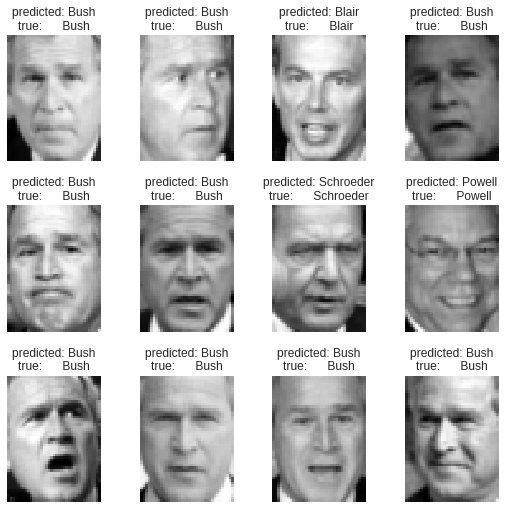

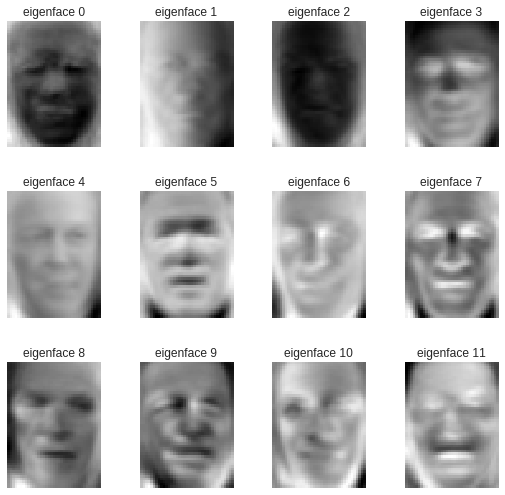

In [0]:
# Qualitative evaluation of the predictions using matplotlib

# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

# **Plotting Unfunnelled **

 Some of the Images have different poses than the funnelled one

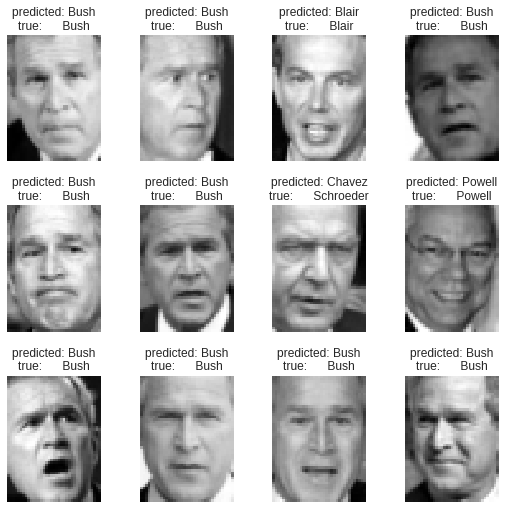

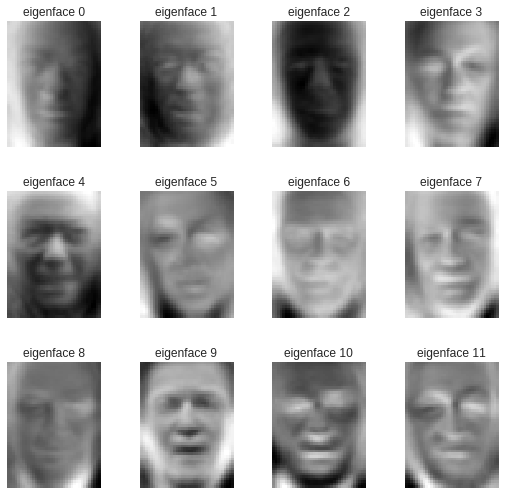

In [0]:
# Qualitative evaluation of the predictions using matplotlib

# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

###Now, disable PCA.
###Standardization

In [0]:
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


###SVM classification model, after standardization

In [0]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()

param_grid = {'C': [1, 10, 100, 1e3]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_scaled, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 112.101s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


###Evaluation

In [0]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_scaled)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.901s
                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.62      0.70        13
     Colin Powell       0.81      0.92      0.86        60
  Donald Rumsfeld       0.83      0.56      0.67        27
    George W Bush       0.83      0.96      0.89       146
Gerhard Schroeder       0.82      0.72      0.77        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.85      0.64      0.73        36

      avg / total       0.83      0.83      0.82       322

[[  8   2   1   2   0   0   0]
 [  1  55   0   3   0   0   1]
 [  1   3  15   8   0   0   0]
 [  0   3   1 140   2   0   0]
 [  0   0   0   3  18   1   3]
 [  0   4   0   3   0   8   0]
 [  0   1   1   9   2   0  23]]


###Plotting

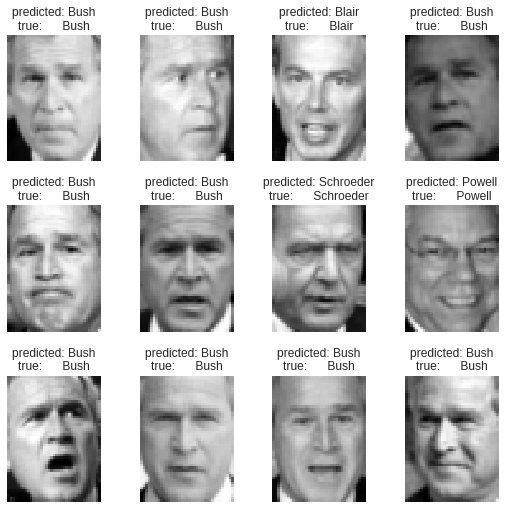

In [0]:
# plot the result of the prediction on a portion of the test set

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

plt.show()

##Classification of cancer gene expressions
###Uploading the training and testing data

In [27]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 14cancer.xtest.csv to 14cancer.xtest.csv
Saving 14cancer.xtrain.csv to 14cancer.xtrain.csv
Saving 14cancer.ytest.csv to 14cancer.ytest.csv
Saving 14cancer.ytrain.csv to 14cancer.ytrain.csv
User uploaded file "14cancer.xtest.csv" with length 3233194 bytes
User uploaded file "14cancer.xtrain.csv" with length 8710218 bytes
User uploaded file "14cancer.ytest.csv" with length 277 bytes
User uploaded file "14cancer.ytrain.csv" with length 802 bytes


###Loading the data

In [0]:
#X_train_df = pd.read_fwf('14cancer.xtrain.txt')
X_train_df = pd.read_csv('14cancer.xtrain.csv')
X_train = np.array(X_train_df.T)

#X_test_df = pd.read_fwf('14cancer.xtest.txt')
X_test_df = pd.read_csv('14cancer.xtest.csv')
X_test = np.array(X_test_df.T)

#y_train_df = pd.read_fwf('14cancer.ytrain.txt')
y_train_df = pd.read_csv('14cancer.ytrain.csv')
y_train = np.array(y_train_df.T)

#y_test_df = pd.read_fwf('14cancer.ytest.txt')
y_test_df = pd.read_csv('14cancer.ytest.csv')
y_test = np.array(y_test_df.T)

###Computing PCA

In [53]:
n_components = 90
n_components_threshold = 135
n_components_array = []
scores_array = []
big_step = 5
small_step = 2;

while True:
  if(n_components >= n_components_threshold):
    break
  
  t0 = time()
  pca = PCA(n_components=n_components, svd_solver='randomized',
            whiten=True).fit(X_train)
  print("done in %0.3fs" % (time() - t0))

  t0 = time()
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)

  print("done in %0.3fs" % (time() - t0))

  #################################################################
  # Train a SVM classification model

  print("Fitting the classifier to the training set")
  t0 = time()
  # best C was 1000 and remained the same after adding lower values
  param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
                'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
  clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                     param_grid, cv=5)
  clf = clf.fit(X_train_pca, y_train)
  print("done in %0.3fs" % (time() - t0))
  print("Best estimator found by grid search:")
  print(clf.best_estimator_)


  #################################################################
  # Quantitative evaluation of the model quality on the test set

  t0 = time()
  y_pred = clf.predict(X_test_pca)
  print("done in %0.3fs" % (time() - t0))

  #print(classification_report(y_test, y_pred, target_names=target_names))
  
  scores_array.append(precision_score(y_test, y_pred, average='micro'))
  n_components_array.append(n_components)
  
  if (n_components > 104 and n_components < 114):
    n_components += small_step
  else:
    n_components += big_step


done in 0.763s
done in 0.062s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.042s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.027s
done in 0.071s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.140s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.087s
done in 0.068s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.236s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.143s
done in 0.071s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.479s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.181s
done in 0.077s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.396s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.125s
done in 0.075s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.376s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.212s
done in 0.073s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.393s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.260s
done in 0.070s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.413s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.175s
done in 0.074s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.455s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.188s
done in 0.076s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.537s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.313s
done in 0.065s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.639s
Best estimator found by grid search:
SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s
done in 1.248s
done in 0.073s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

done in 3.724s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
done in 0.002s


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

###Plotting the scores vs the number of components

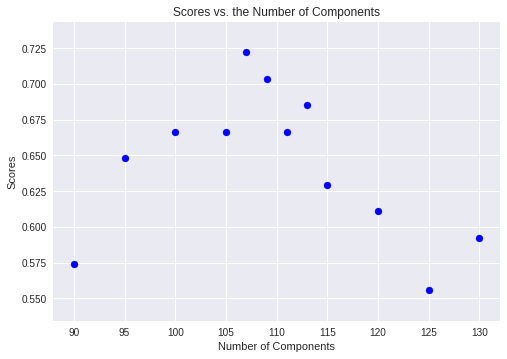

In [54]:
fig,ax = plt.subplots()
ax.set_xlabel('Number of Components')
ax.set_ylabel('Scores')
ax.set_title('Scores vs. the Number of Components')
plt.scatter(n_components_array, scores_array, c='b')

plt.show()

###Hierarchical Clustering

In [91]:
print("Compute unstructured hierarchical clustering...")
st = time()
average = AgglomerativeClustering(n_clusters=14, linkage='ward').fit(X_train)
elapsed_time = time() - st
label = average.labels_
print("Elapsed time: %.2fs" % elapsed_time)
print("Number of points: %i" % label.size)

Compute unstructured hierarchical clustering...
Elapsed time: 0.19s
Number of points: 144


###Plot the result

Text(0.5,0.92,'Without connectivity constraints (time 0.19s)')

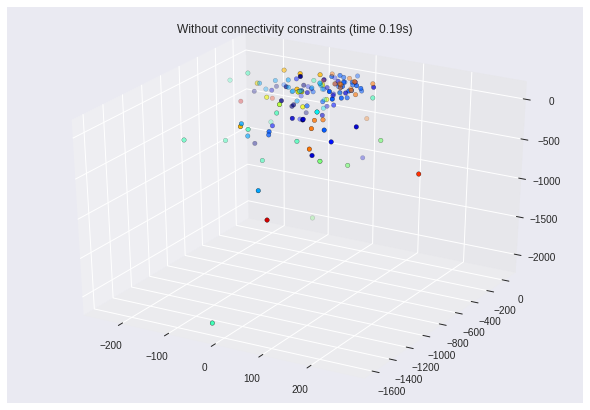

In [92]:
fig = plt.figure()
ax = p3.Axes3D(fig)
#ax.view_init(7, -80)
for l in np.unique(label):
    ax.scatter(X_train[label == l, 0], X_train[label == l, 1], X_train[label == l, 2],
               color=plt.cm.jet(np.float(l) / np.max(label + 1)),
               s=20, edgecolor='k')
plt.title('Without connectivity constraints (time %.2fs)' % elapsed_time)

###Homogeneity metric

In [93]:
print(homogeneity_score(y_train.flatten(), label))

0.5239153465174028
